In [1]:
# Library to dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od

# Library tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Surpress warning
import warnings
warnings.filterwarnings("ignore")

# Library sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# pickle
import pickle

In [2]:
data = pd.read_csv('F:/Works/Mental Health Disorder/Dataset/clean_text.csv')
data.head()

,text,class,clean_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently left my wi...
1,Am I weird I don't get affected by compliments...,non-suicide,am weird don get affected by compliments if it...
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally is almost over so can never hear has b...
3,i need helpjust help me im crying so hard,suicide,i need helpjust help me im crying so hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,i so losthello my name is adam and ve been str...


In [3]:
X = data['clean_text'].astype(str)
y = data['class']

# encode class values as integers
# Define label encoder
encoder = LabelEncoder()
# fit and transform
encoded_y = encoder.fit_transform(y)

In [4]:
# Test and train split
X_train, X_test, y_train, y_test = train_test_split(X,encoded_y, test_size=.2, random_state=42)

In [5]:
vocab_size = 10_000
max_length = 10_000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(y_train)
testing_labels = np.array(y_test)

In [6]:
# Save the word index dictionary
np.save('F:/Works/Mental Health Disorder/word_index.npy', word_index)

# Save Tokenizer
with open('F:/Works/Mental Health Disorder/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
embedding_dim = 16

# Initialize the model
model_GlobalAveragePooling1D = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_GlobalAveragePooling1D.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_GlobalAveragePooling1D.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="F:/Works/Mental Health Disorder/Model Basic + Global Average Pooling.keras", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=10, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [9]:
num_epochs = 60

# Train the model
history_GlobalAveragePooling1D = model_GlobalAveragePooling1D.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), callbacks=callbacks)

Epoch 1/60
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5188 - loss: 0.6911
Epoch 1: val_accuracy improved from -inf to 0.49837, saving model to F:/Works/Mental Health Disorder/Model Basic + Global Average Pooling.keras
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 260s 41ms/step - accuracy: 0.5188 - loss: 0.6911 - val_accuracy: 0.4984 - val_loss: 0.6323 - learning_rate: 0.0010
Epoch 2/60
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6259 - loss: 0.6390
Epoch 2: val_accuracy improved from 0.49837 to 0.71216, saving model to F:/Works/Mental Health Disorder/Model Basic + Global Average Pooling.keras
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 240s 41ms/step - accuracy: 0.6259 - loss: 0.6390 - val_accuracy: 0.7122 - val_loss: 0.5527 - learning_rate: 0.0010
Epoch 3/60
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7409 - loss: 0.5392
Epoch 3: val_accuracy improved from 0.71216 to 0.74034, saving model to F:/Works/Mental Health Disorder/Model Basic + Global Average Pooling.keras
580

In [10]:
# Evaluate the model
results_GlobalAveragePooling1D = model_GlobalAveragePooling1D.evaluate(testing_padded, testing_labels)

# print results
print(f'Test results - Loss: {results_GlobalAveragePooling1D[0]} - Accuracy: {100*results_GlobalAveragePooling1D[1]}%')

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9185 - loss: 0.2119
Test results - Loss: 0.21188688278198242 - Accuracy: 91.84961915016174%


In [12]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

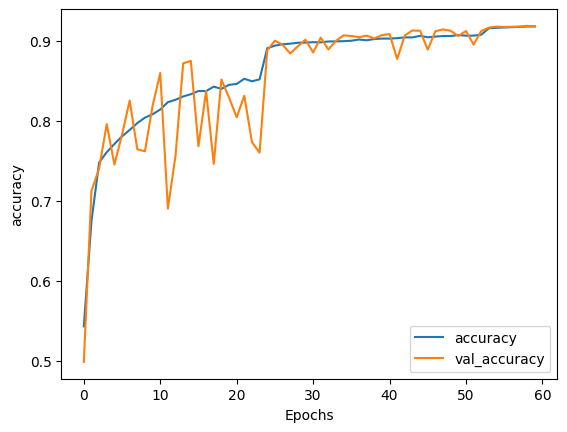

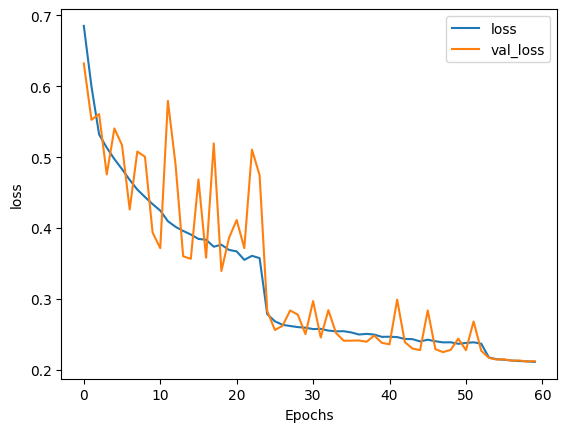

In [13]:
# Plot the accuracy and loss
plot_graphs(history_GlobalAveragePooling1D, "accuracy")
plot_graphs(history_GlobalAveragePooling1D, "loss")